In [1]:
import pandas as pd #pands 모듈 불러오기
import matplotlib.pyplot as plt #matplotlib 불러오기
import numpy as np #numpy 모듈 불러오기
#import seaborn as sns; sns.set() #seaborn
import pandas_datareader.data as web #datareader 불러오기
import scipy.optimize as opt #scipy(최적화 도구) 불러오기

data = pd.DataFrame() 
#삼성전자, sk하이닉스, 카카오, 네이버  data 불러오기
for code in ['005930', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)
    #해당 코드를 네이버 증권에서 불러오라, 종가로, int형으로
    #데이터 프레임 합치기
    #axis=1 오른쪽으로 열 추가하는 방식 / axis = 0 행추가 방식

data.columns = ['se', 'skh', 'kk','nvr'] #데이터의 열 이름 지정
noa = len(data.columns) #4개

ret = data.pct_change().dropna() #퍼센트 변화율

ret.mean() #각 종목별 변화율의 평균

se     0.001595
skh    0.002043
kk     0.001828
nvr    0.002078
dtype: float64

In [2]:
port_rets = [] #return값
port_std = [] #표준편차값
ret = data.pct_change().dropna() #퍼센트 변화율

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *250) #수익률의 평균
    port_var = np.dot(weight.T, np.dot(ret.cov()*250, weight)) #분산
    port_std = np.sqrt(port_var) #표준편차
    
    return port_mean, port_std #red_std : 평균, 표준편차를 돌려줌

for w in range(2500):  #2500번 
    weight = np.random.random(noa) #noa(4개) 난수 생성하기
    weight /= np.sum(weight) #합이 1인 서로 다른 w1~w4의 조합을 생성하기
    
    mu, sig = ret_std(weight, ret) #mu = 표본평균, std = 표본 표준편차
#     print(mu, sig)
    port_rets.append(mu) #prot_rets = [mu들의 집합]
    port_std.append(sig) #prot_rets = [sig들의 집합]
    #각각의 mean과 std를 append

def statistics(weights, rf=0):
    weights = np.array(weights) #자산의 weights들 조합
    pret = np.sum(ret.mean() * weights) * 252 - rf # μ-rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights))) #행렬곱 -> σ
    
    return np.array([pret, pvol, pret / pvol]) # μ-rf , σ, sharp ratio

def min_func_sharpe(weights, rf=0): #sharp ratio가 가장 큰 조합을 구하는 함수
    return -statistics(weights, rf)[2] #index=2라는 건 sharp ratio를 돌려주라는 거(-붙였으니 최댓값)

def min_func_volatility(weights):
    return statistics(weights)[1] **2 #variance를 최소화

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) #제약식 , w의 합이 1과 같아야 한다
bnds = tuple((0, 1) for x in range(noa)) #0~1 범위 내에서만 생성해야 한다
noa * [1. / noa,] #0.25

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
        #sharp ratio를 가장 크게 만드는 weight를 구하는 함수
optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
        #variance를 최소화하는 weight를 구하는 함수

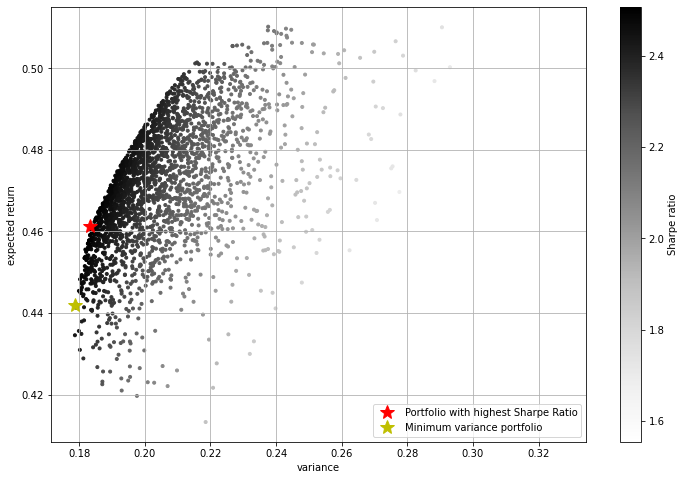

In [3]:
plt.figure(figsize=(12, 8)) #그림의 크기 (12,8)
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys') # random portfolio composition
#x축 : 표본 표준편차, y축 : 표본평균 
#c :점의 색깔 변화가 μ/σ를 따라서(대각선으로)
#marker : 점의 모양(크기)
    
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            # statistics(opts['x'])[1] : opts의 x값 즉 최적화하는 weight들을 statistics에 넣어 나온 σ
            # statistics(opts['x'])[0] : weights를 넣어 구한 평균
        
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0, label = 'Minimum variance portfolio')
            # variance를 최소화하는 weights들로 σ와 μ 구한다
    
plt.legend()#범례
plt.grid(True)#격자무늬
plt.xlabel('variance')#x축 라벨
plt.ylabel('expected return') #y축 라벨
plt.colorbar(label='Sharpe ratio') #컬러바 라벨

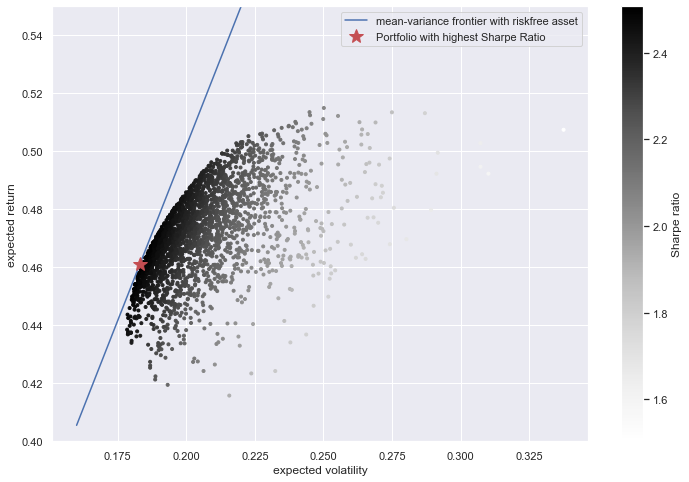

In [41]:
var_list = [x*slope + rf for x in np.linspace(0.16,0.30,2500)]
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
#기울기는 수익을 최대화하는 조합의 μ/σ


x =  np.linspace(0.16,0.30,2500) #0.16~0.30개까지 일정 간격으로 2500개 실수 생성
y = var_list

plt.figure(figsize=(12, 8)) #그림의 크기 (12,8)

plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.',cmap = 'Greys')
            #표준편차 y축, 표본 평균 x축으로 점 그래프 그리기
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')
            # random portfolio composition  
            # x에 대해 나올 수 있는 return을 직선으로 그리기
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
            #최적 값으로 구한 점
            # portfolio with highest Sharpe ratio
plt.ylim((0.4, 0.55)) #y축 범위

plt.legend() #범례
plt.grid(True) #격자무늬
plt.xlabel('expected volatility') #x축 라벨
plt.ylabel('expected return') #y축 라벨
plt.colorbar(label='Sharpe ratio') #컬러바 라벨